# Policy Gradients on CartPole with PyTorch 1.0

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import namedtuple, deque


In [2]:
env = gym.make('CartPole-v1')
print(torch.__version__)

# Hyperparameters
learning_rate = 1e-4
gamma = 0.99
soft_tau=5e-3
batch_size = 256

1.5.0+cu101


# Define model and training loop

In [0]:

class Replay_Buffer(object):
    """Replay buffer to store past experiences that the agent can then use for training data"""
    
    def __init__(self, buffer_size, batch_size, seed=0):

        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def add_experience(self, states, actions, rewards, next_states, dones):
        """Adds experience(s) into the replay buffer"""
        if type(dones) == list:
            assert type(dones[0]) != list, "A done shouldn't be a list"
            experiences = [self.experience(state, action, reward, next_state, done)
                           for state, action, reward, next_state, done in
                           zip(states, actions, rewards, next_states, dones)]
            self.memory.extend(experiences)
        else:
            experience = self.experience(states, actions, rewards, next_states, dones)
            self.memory.append(experience)
   
    def sample(self, num_experiences=None, separate_out_data_types=True):
        """Draws a random sample of experience from the replay buffer"""
        experiences = self.pick_experiences(num_experiences)
        if separate_out_data_types:
            states, actions, rewards, next_states, dones = self.separate_out_data_types(experiences)
            return states, actions, rewards, next_states, dones
        else:
            return experiences
            
    def separate_out_data_types(self, experiences):
        """Puts the sampled experience into the correct format for a PyTorch neural network"""
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([int(e.done) for e in experiences if e is not None])).float().to(self.device)
        
        return states, actions, rewards, next_states, dones
    
    def pick_experiences(self, num_experiences=None):
        if num_experiences is not None: batch_size = num_experiences
        else: batch_size = self.batch_size
        return random.sample(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
# https://stackoverflow.com/questions/56226133/soft-actor-critic-with-discrete-action-space
# ... for discrete action, GumbelSoftmax distribution
class GumbelSoftmax(torch.distributions.RelaxedOneHotCategorical):
    '''
    A differentiable Categorical distribution using reparametrization trick with Gumbel-Softmax
    Explanation http://amid.fish/assets/gumbel.html
    NOTE: use this in place PyTorch's RelaxedOneHotCategorical distribution since its log_prob is not working right (returns positive values)
    Papers:
    [1] The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables (Maddison et al, 2017)
    [2] Categorical Reparametrization with Gumbel-Softmax (Jang et al, 2017)
    '''

    def sample(self, sample_shape=torch.Size()):
        '''Gumbel-softmax sampling. Note rsample is inherited from RelaxedOneHotCategorical'''
        u = torch.empty(self.logits.size(), device=self.logits.device, dtype=self.logits.dtype).uniform_(0, 1)
        noisy_logits = self.logits - torch.log(-torch.log(u))
        return torch.argmax(noisy_logits, dim=-1)

    def log_prob(self, value):
        '''value is one-hot or relaxed'''
        if value.shape != self.logits.shape:
            value = F.one_hot(value.long(), self.logits.shape[-1]).float()
            assert value.shape == self.logits.shape
        return - torch.sum(- value * F.log_softmax(self.logits, -1), -1)


In [0]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 256
        target_entropy_ratio = .95

        self.l1 = nn.Linear(state_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_hidden)
        self.l3 = nn.Linear(num_hidden, action_space)

        self.target_entropy = -np.log(1.0/env.action_space.n) * target_entropy_ratio
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha = self.log_alpha.detach().exp()

        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy and reward history
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l3,
            nn.Softmax(dim=-1)
        )
        return model(x)

    def act(self, state):
        # Select an action (0 or 1) by running policy model
        # and choosing based on the probabilities in state
        action_probs = self.forward(state)
        action = torch.distributions.Categorical(probs=action_probs).sample().cpu()
        return action.cpu().squeeze()

    def calc_log_prob_action(self, state, reparam=False):
        
        action_probs = self.forward(state)
        action_pd = GumbelSoftmax(probs=action_probs, temperature=1)
        actions = action_pd.rsample() if reparam else action_pd.sample()
        log_probs = action_pd.log_prob(actions)
        return log_probs, actions


class SoftQNetwork(nn.Module):
    def __init__(self):
        super(SoftQNetwork, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        num_hidden = 256

        self.l1 = nn.Linear(self.state_space + self.action_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_hidden)
        self.l3 = nn.Linear(num_hidden, 1)

    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l2,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.l3
        )
        return model(x).view(-1)




In [0]:

def guard_q_actions(actions, dim):
    '''Guard to convert actions to one-hot for input to Q-network'''
    actions = F.one_hot(actions.long(), dim).float()
    return actions

def calculate_critic_loss(states, actions, rewards, next_states, done):
    with torch.no_grad():
        next_probs, next_actions = policy.calc_log_prob_action(next_states)
        next_actions = guard_q_actions(next_actions, tgt_q_net1.action_space)
        next_q1 = tgt_q_net1(next_states, next_actions)
        next_q2 = tgt_q_net2(next_states, next_actions)

        min_q_next = (torch.min(next_q1, next_q2) - policy.alpha * next_probs)
        target_q_value = rewards + (1 - done) * gamma * min_q_next

    p_q1 = soft_q_net1(states, actions)
    p_q2 = soft_q_net2(states, actions)
    q_value_loss1 = F.mse_loss(p_q1, target_q_value)
    q_value_loss2 = F.mse_loss(p_q2, target_q_value)
    return q_value_loss1, q_value_loss2

def calculate_actor_loss(states):
     # Train actor network
    log_probs, actions = policy.calc_log_prob_action(states, reparam=True)
    q1 = soft_q_net1(states, actions)
    q2 = soft_q_net2(states, actions)
    min_q = torch.min(q1, q2)
    policy_loss = (policy.alpha * log_probs - min_q).mean()
    return policy_loss, log_probs

def calculate_entropy_tuning_loss(log_pi):
    """Calculates the loss for the entropy temperature parameter. This is only relevant if self.automatic_entropy_tuning
    is True."""
    alpha_loss = -(policy.log_alpha * (log_pi.detach() + policy.target_entropy)).mean()
    return alpha_loss

def update(replay):
    # Soft Q networks are the problem, detach gradient?  Not sure why they are the cause
    states, action, reward, next_states, done = replay.sample(batch_size)
    action = action.squeeze(1)
    reward = reward.squeeze(1)
    done = done.squeeze(1)
    if not math.isnan(reward.std()):
        reward = (reward - reward.mean()) / (reward.std() + np.finfo(np.float32).eps)
    action = guard_q_actions(action, soft_q_net1.action_space)
    q_value_loss1, q_value_loss2 = calculate_critic_loss(states, action, reward, next_states, done) 
    q1_opt.zero_grad()
    q_value_loss1.backward()
    torch.nn.utils.clip_grad_norm_(soft_q_net1.parameters(), 5.)
    q1_opt.step()
    q2_opt.zero_grad()
    q_value_loss2.backward()
    torch.nn.utils.clip_grad_norm_(soft_q_net2.parameters(), 5.)
    q2_opt.step()  

    policy_loss, log_action_probabilities = calculate_actor_loss(states)
    policy_opt.zero_grad()
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 5.)
    policy_opt.step()

    alpha_loss = calculate_entropy_tuning_loss(log_action_probabilities) 
    entropy_opt.zero_grad()
    alpha_loss.backward()
    entropy_opt.step()
    
    loss = q_value_loss1 + q_value_loss2 + policy_loss + alpha_loss
    policy.alpha = policy.log_alpha.detach().exp()

    for target_param, param in zip(tgt_q_net1.parameters(), soft_q_net1.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
    
    for target_param, param in zip(tgt_q_net2.parameters(), soft_q_net2.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
    # Save and intialize episode history counters
    policy.loss_history.append(policy_loss.item())
    policy.reset()
    del policy.rewards[:]
    del policy.saved_log_probs[:]



In [0]:

def train(episodes):
    scores = []
    replay = Replay_Buffer(1000000, batch_size)
    global_step = 0
    for episode in range(episodes):
        # Reset environment and record the starting state
        state = env.reset()
        reward_cum = 0
        for time in range(1000):
            state_inp = torch.from_numpy(state).float().to(device)
            if (global_step < 100):
                action = env.action_space.sample()
            else:
                action = policy.act(state_inp)
                action = action.item()

            # Uncomment to render the visual state in a window
            # Step through environment using chosen action
            next_state, reward, done, _ = env.step(action)
            replay.add_experience(state, action, reward, next_state, done)
            state = next_state
            reward_cum += reward
            global_step +=1
            if len(replay) > batch_size:
                update(replay)
            if done:
                break

        # Calculate score to determine when the environment has been solved
        scores.append(time)
        policy.reward_history.append(reward_cum)
        mean_score = np.mean(scores[-100:])

        if episode % 50 == 0:
            print('Episode {}\tAverage length (last 100 episodes): {:.2f}'.format(
                episode, mean_score))

        if mean_score > env.spec.reward_threshold:
            print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
                  .format(episode, mean_score, time))
            break

# Start training

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
policy = Policy().to(device)
soft_q_net1 = SoftQNetwork().to(device)
soft_q_net2 = SoftQNetwork().to(device)
tgt_q_net1 = SoftQNetwork().to(device).eval()
tgt_q_net2 = SoftQNetwork().to(device).eval()

for target_param, param in zip(tgt_q_net1.parameters(), soft_q_net1.parameters()):
    target_param.data.copy_( param.data)
for target_param, param in zip(tgt_q_net2.parameters(), soft_q_net2.parameters()):
    target_param.data.copy_( param.data)
for param in tgt_q_net1.parameters():
    param.requires_grad = False
for param in tgt_q_net2.parameters():
    param.requires_grad = False

policy_opt = optim.Adam(policy.parameters(), lr=learning_rate, eps=1e-4)
entropy_opt = optim.Adam([policy.log_alpha], lr=learning_rate, eps=1e-4)
q1_opt = optim.Adam(soft_q_net1.parameters(), lr=learning_rate, eps=1e-4)
q2_opt = optim.Adam(soft_q_net2.parameters(), lr=learning_rate, eps=1e-4)
train(episodes=1000)

cuda
Episode 0	Average length (last 100 episodes): 31.00
Episode 50	Average length (last 100 episodes): 20.49
Episode 100	Average length (last 100 episodes): 34.53
Episode 150	Average length (last 100 episodes): 103.08
Episode 200	Average length (last 100 episodes): 180.32
Episode 250	Average length (last 100 episodes): 235.24
Episode 300	Average length (last 100 episodes): 277.17
Episode 350	Average length (last 100 episodes): 301.56
Episode 400	Average length (last 100 episodes): 284.72
Episode 450	Average length (last 100 episodes): 270.35
Episode 500	Average length (last 100 episodes): 277.82
Episode 550	Average length (last 100 episodes): 280.32
Episode 600	Average length (last 100 episodes): 276.59
Episode 650	Average length (last 100 episodes): 281.14
Episode 700	Average length (last 100 episodes): 299.29
Episode 750	Average length (last 100 episodes): 301.52
Episode 800	Average length (last 100 episodes): 295.88
Episode 850	Average length (last 100 episodes): 260.55
Episode 900

# Plot training performance

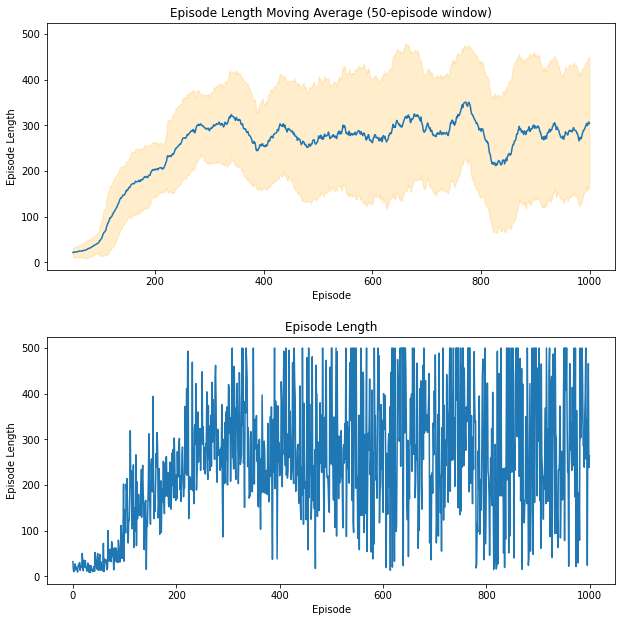

In [9]:
# number of episodes for rolling average
window = 50

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()